<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-исследования" data-toc-modified-id="Описание-исследования-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание исследования</a></span></li></ul></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

### Описание исследования 

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Цель исследования**: спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно. Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.


**Исходные данные** 

Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки:

    RowNumber — индекс строки в данных
    CustomerId — уникальный идентификатор клиента
    Surname — фамилия
    CreditScore — кредитный рейтинг
    Geography — страна проживания
    Gender — пол
    Age — возраст
    Tenure — сколько лет человек является клиентом банка
    Balance — баланс на счёте
    NumOfProducts — количество продуктов банка, используемых клиентом
    HasCrCard — наличие кредитной карты
    IsActiveMember — активность клиента
    EstimatedSalary — предполагаемая зарплата
    
Целевой признак:

    Exited — факт ухода клиент


## Подготовка данных

In [1]:
#Импортируем библиотеки 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.utils import shuffle

Откроем таблицу с данными, изучим общую информацию о данных:

In [2]:
try:
    data = pd.read_csv('C:\\Users\\vasil\\Downloads\\ML_2\\Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')
    
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data['HasCrCard'].value_counts() #сумма уникальных значений в столбце

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [5]:
data['IsActiveMember'].value_counts() #сумма уникальных значений в столбце

1    5151
0    4849
Name: IsActiveMember, dtype: int64

In [6]:
data['Tenure'].isnull().mean() #доля пропусков в столбце Tenure

0.0909

In [7]:
data.Exited.value_counts() #cоотношение классов в выборке

0    7963
1    2037
Name: Exited, dtype: int64

Для построения модели, с прогнозом уйдет ли клиент из банка, необходимы признакими, которые позволяют оценить поведение клиента, поэтому столбцы RowNumber, CustomerId, Surname удалим из таблицы, как незначимые для анализа. 

Единственный столбец, имеющий пропуски Tenure значим для прогнозирования, при этом доля пропусков 9%. Но не будем принебрегать этой долей и терять данные, ведь в таблице наблюдается неравное соотношение классов и удаление строк с положительными значениями целевого признаками может ухудшить качество модели. Поэтому сохраним данные, которые есть. Пропуски в столбце обработаем нулем, а для того, чтобы алгоритм понимал, что это пропуски добавим столбец  tenure_isnull, в котором 1 означает наличие пропуска в столбце. 

Приведем название всех столбцов таблицы к нижнему регистру. 

In [8]:
data.columns = data.columns.str.lower()

In [9]:
data.drop(columns=['rownumber', 'customerid', 'surname'], inplace=True)
data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [10]:
data['tenure'] = data['tenure'].fillna(0)

In [11]:
#формула для создания фиктивного признака 

def tenure_isnull(tenure):
    if tenure == 0:
        return 1
    return 0 

In [12]:
data['tenure_isnull'] = data['tenure'].apply(tenure_isnull)
data.tail()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,tenure_isnull
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,0
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,0
9999,792,France,Female,28,0.0,130142.79,1,1,0,38190.78,0,1


В данных есть 2 категориальных признака преобразуем их техникой OHE.

In [13]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [14]:
target = data_ohe['exited']
features = data_ohe.drop(['exited'] , axis=1)

Для обучения модели и проверки ее качества разделим исходную таблицу на тренировочную, валидационную и тестовую. Данных немного, поэтому наибольшую долю заложим на обучение, разделим все данные в пропорции: 80%-10%-10%

In [15]:
#разделим обучающую и валидационную выборки

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345) 

In [16]:
#разделим валидационную и тренировочную выборки
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345) 

In [17]:
#проверим размеры выборок 
features_train.shape, features_valid.shape, features_test.shape 

((8000, 12), (1000, 12), (1000, 12))

Приведем численные признаки к одному масштабу:


In [18]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 
           'estimatedsalary', 'tenure_isnull']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head(), features_valid.head(), features_test.head()

C:\Users\vasil\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


(      creditscore       age    tenure   balance  numofproducts  hascrcard  \
 454      1.107585  0.011482  0.466088  0.819420      -0.899779  -1.551033   
 8307    -0.338704 -0.844298 -0.496821  0.923294      -0.899779   0.644731   
 4811    -0.782922 -1.224645  0.787058 -1.220083       0.811234   0.644731   
 1132    -0.235398 -0.178692 -1.459730 -1.220083       0.811234   0.644731   
 9640     1.024940 -0.368865 -0.496821 -1.220083      -0.899779   0.644731   
 
       isactivemember  estimatedsalary  tenure_isnull  geography_Germany  \
 454         0.960528        -0.757878       -0.38805                  0   
 8307        0.960528        -1.194506       -0.38805                  0   
 4811       -1.041094         0.212357       -0.38805                  0   
 1132        0.960528         1.239310        2.57699                  0   
 9640       -1.041094         1.583001       -0.38805                  0   
 
       geography_Spain  gender_Male  
 454                 0            

## Исследование задачи

Исследуем баланс классов в выборке:

In [19]:
class_frequency = data_ohe['exited'].value_counts(normalize=2/len(data['exited']))
class_frequency

0    0.7963
1    0.2037
Name: exited, dtype: float64

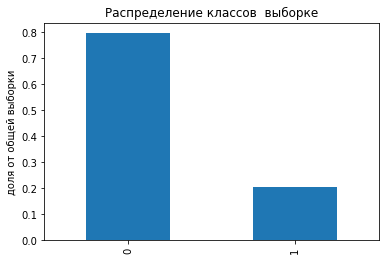

In [20]:
class_frequency.plot(kind='bar', title="Распределение классов  выборке", ylabel= 'доля от общей выборки') 

plt.show()

В общей выборке класс 0 составляет почти 80%, наблюдается явный дисбаланс классов, который повлияет на предсказания модели, положительные результаты она будет предсказывать хуже. Для начала обучим модель без учета дисбаланса классов.

In [21]:
log_reg = LogisticRegression(random_state=12345, solver='liblinear') 
log_reg.fit(features_train, target_train)
predictions_valid = log_reg.predict(features_valid) 

accuracy_score(target_valid, predictions_valid) 

0.785

Доля правильных ответов 78,5%, но одной метрики для оценки качества не достаточно, проверим модель на адекватность, сравним её accuracy с константной моделью. 

In [22]:
target_pred_constant = pd.Series(0, index=target_train.index) #константная модель прогнозирует класс 0 любому объекту 

accuracy_score(target_train, target_pred_constant) 

0.79875

Модель логистической регрессии предсказывает хуже, чем константная модель. Получается, что модель не адектвана, построим для нее матрицу ошибок

In [23]:
confusion_matrix(target_valid, predictions_valid)

array([[741,  34],
       [181,  44]], dtype=int64)

Предсказывая положительный класс, модель чаще делает ошибки (181 ложно положительных), чем предсказывает верно (44 истино положительных). Посчитаем еще 2 метрики, оценивающие качетсво модели: полноту и точность. 

In [24]:
recall_score(target_valid, predictions_valid)

0.19555555555555557

Модель предсказывает 19% положительных ответов из всех ответов, являющихся положительными.  

In [25]:
precision_score(target_valid, predictions_valid)

0.5641025641025641

 56% предсказаний, которые модель определяет как положительные, являются положительными. 
Завершим анализ вычислением f1-меры. 

In [26]:
f1_score(target_valid, predictions_valid)

0.29042904290429045

In [27]:
#Решающее дерево 

best_tree = None
best_result = 0
best_depth = 0 #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for depth in range(1, 12):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) #в цикле будем изменять значения параметра глубины 
    tree.fit(features_train, target_train) #обучаем модель на тренировочной выборке
    predictions_valid_tree = tree.predict(features_valid) 
    result = f1_score(target_valid, predictions_valid_tree) #определяем качество модели на валидационной выборке
    if result > best_result:
        best_tree = tree #сохраним наилучшую модель
        best_result = result #сохраним наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth #сохраним наилучшее значение гиперпараметра 
        
best_result, best_depth 

(0.5882352941176471, 5)

In [28]:
#Случайный лес 

best_forest = None
best_result_forest = 0 
best_estimators = 0 
best_depth_forest1 = 0  #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for est in range (100, 1001, 100):
    for depth2 in range (1, 22, 2):
        forest2  = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth2) #в цикле будем изменять количество деревьев
        forest2.fit(features_train, target_train) #обучаем модель на тренировочной выборке
        predictions_valid_forest  = forest2.predict(features_valid) #получим предсказания на валидационной выборке
        result2 = f1_score(target_valid, predictions_valid_forest) #определяем качество модели на валидационной выборке
        if result2 > best_result_forest:
            best_forest = forest2 #сохраним наилучшую модель
            best_result_forest = result2 #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_estimators = est #сохраним наилучшее значение гиперпараметра 
            best_depth = depth2 #сохраним наилучшее значение гиперпараметра                               

best_result_forest,  best_estimators, best_depth

(0.5868945868945868, 200, 21)

**Вывод**

Была обучена модель логистической регрессии без учета дисбаланса и оценено ее качесто. Метрика accuracy составила 0,78 и оказалась ниже, чем accuracy константной модели.

Метрики полноты и точности составили 0,19 и 0,56, среднее гармоническое этих метрик 0,29. Матрица ошибок, как и все 3 метрики показывают, что предсказывая положительный класс, модель чаще делает ошибки, чем предсказывает верно.

С учетом проведенного анализа, сделаем вывод, что ошибок при оценке класса 1 недопустимо много, требуется доработать модель в части сбалансированности классов.

У модели решающего дерева и случайного леса f1_score значительно выше, чем у логистической регрессии.

## Борьба с дисбалансом

Для улучшения качества модели, подберем метод устранения дисбаланса, при котором получим наулучшее значение f1-меры. 


**Метод взвешивания классов**

In [29]:
#Логистическая регрессия 

log_reg2 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced') 
log_reg2.fit(features_train, target_train)
predictions_valid2 = log_reg2.predict(features_valid) 

f1_score(target_valid, predictions_valid2)

0.5047619047619047

Метод позволил увеличить f1-меру почти на 30 пунктов

In [30]:
#Решающее дерево 

best_tree1 = None
best_result_tree1 = 0
best_depth1 = 0 
for depth1 in range(1, 22, 2):
    tree1 = DecisionTreeClassifier(random_state=12345, max_depth=depth1, class_weight='balanced') #обучаем модель на тренировочной выборке с агументом взвешивания классов) #обучаем модель на тренировочной выборке с агументом взвешивания классов
    tree1.fit(features_train, target_train) 
    predictions_valid_tree1 = tree1.predict(features_valid) 
    result1 = f1_score(target_valid, predictions_valid_tree1) 
    if result1 > best_result_tree1:
        best_tree1 = tree1 #сохраним наилучшую модель
        best_result_tree1 = result1 #сохраним наилучшее значение метрики accuracy на валидационных данных
        best_depth1 = depth1 #сохраним наилучшее значение гиперпараметра 
        
best_result_tree1 , best_depth1

(0.5959595959595959, 7)

Значение метрики улучшилось незначительно (исходное значение 0.5882)

In [31]:
#Случайный лес 

best_forest = None
best_result_forest = 0 
best_estimators = 0 
best_depth_forest1 = 0  #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for est in range (100, 1001, 100):
    for depth2 in range (1, 22, 2):
        forest2  = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth2, class_weight='balanced') #в цикле будем изменять количество деревьев
        forest2.fit(features_train, target_train) #обучаем модель на тренировочной выборке
        predictions_valid_forest  = forest2.predict(features_valid) #получим предсказания на валидационной выборке
        result2 = f1_score(target_valid, predictions_valid_forest) #определяем качество модели на валидационной выборке
        if result2 > best_result_forest:
            best_forest = forest2 #сохраним наилучшую модель
            best_result_forest = result2 #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_estimators = est #сохраним наилучшее значение гиперпараметра 
            best_depth_forest1 = depth2 #сохраним наилучшее значение гиперпараметра                               

best_result_forest,  best_estimators, best_depth

(0.6603053435114503, 1000, 21)

Значение метрики улучшилось значительно (исходное значение 0.5868)

**Метод увеличения выборки**

In [32]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled 

In [33]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

features_upsampled.shape, target_upsampled.shape

((12830, 12), (12830,))

In [34]:
#Логистическая регрессия 

log_reg3 = LogisticRegression(random_state=12345, solver='liblinear') 
log_reg3.fit(features_upsampled, target_upsampled)
predictions_valid3 = log_reg3.predict(features_valid) 

f1_score(target_valid, predictions_valid3) #обучим модель на новой выборке и оценим ее качество 

0.5063291139240507

f1-мера чуть лучше, чем при взвешивании классов 

In [35]:
#Решающее дерево 

best_tree2 = None
best_result_tree2 = 0
best_depth_tree2 = 0 #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for depth3 in range(1, 22, 2):
    tree2 = DecisionTreeClassifier(random_state=12345, max_depth=depth3) #в цикле будем изменять значения параметра глубины 
    tree2.fit(features_upsampled, target_upsampled) #обучаем модель на тренировочной выборке
    predictions_valid_tree2 = tree2.predict(features_valid) 
    result_tree2 = f1_score(target_valid, predictions_valid_tree2) #определяем качество модели на валидационной выборке
    if result_tree2 > best_result_tree2:
        best_tree2 = tree2 #сохраним наилучшую модель
        best_result_tree2 = result_tree2 #сохраним наилучшее значение метрики accuracy на валидационных данных
        best_depth_tree2 = depth3 #сохраним наилучшее значение гиперпараметра 
        
best_result_tree2, best_depth_tree2 

(0.5973154362416108, 7)

Значение метрики улучшилось незначительно

In [36]:
#Случайный лес

best_forest2 = None
best_result_forest2 = 0 
best_estimators2 = 0 
best_depth_forest2 = 0  #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for est2 in range (100, 1001, 100):
    for depth4 in range (1, 22, 2):
        forest3  = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth4) #в цикле будем изменять количество деревьев
        forest3.fit(features_upsampled, target_upsampled) #обучаем модель на тренировочной выборке
        predictions_valid_forest2  = forest3.predict(features_valid) #получим предсказания на валидационной выборке
        result_forest2 = f1_score(target_valid, predictions_valid_forest2) #определяем качество модели на валидационной выборке
        if result_forest2 > best_result_forest2:
            best_forest2 = forest3 #сохраним наилучшую модель
            best_result_forest2 = result_forest2 #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_estimators2 = est2 #сохраним наилучшее значение гиперпараметра 
            best_depth_forest2 = depth4 #сохраним наилучшее значение гиперпараметра                             
best_result_forest2,  best_estimators2, best_depth_forest2

(0.6556169429097607, 100, 7)

F1-мера при методе увеличения выборки чуть меньше, чем при взвешивании классов 

**Метод уменьшения выборки**

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
 
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
 
    return features_downsampled, target_downsampled 

In [38]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

features_downsampled.shape, target_downsampled.shape 

((4166, 12), (4166,))

In [39]:
#Логистическая регрессия 

log_reg4 = LogisticRegression(random_state=12345, solver='liblinear') 
log_reg4.fit(features_downsampled, target_downsampled)
predictions_valid4 = log_reg4.predict(features_valid) 

f1_score(target_valid, predictions_valid4) 

0.5080645161290323

In [40]:
#Решающее дерево 

best_result = 0
best_depth = 0 #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for depth in range(1, 12):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) #в цикле будем изменять значения параметра глубины 
    tree.fit(features_downsampled, target_downsampled) #обучаем модель на тренировочной выборке
    predictions_valid_tree = tree.predict(features_valid) 
    result = f1_score(target_valid, predictions_valid_tree) #определяем качество модели на валидационной выборке
    if result > best_result:
        best_tree = tree #сохраним наилучшую модель
        best_result = result #сохраним наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth #сохраним наилучшее значение гиперпараметра 
        
best_result, best_depth 

(0.6385542168674699, 5)

Это лучшее f1-меры для модели решающего дерева

In [41]:
#Случайный лес 

best_forest = None
best_result2 = 0 
best_estimators = 0 
best_depth2 = 0  #введем переменные для поиска лучшей модели, которые далее применим в цикле 

for est in range (100, 500, 100):
    for depth2 in range (1, 11, 2):
        forest  = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth2) #в цикле будем изменять количество деревьев
        forest.fit(features_downsampled, target_downsampled) #обучаем модель на тренировочной выборке
        predictions_valid_forest  = forest.predict(features_valid) #получим предсказания на валидационной выборке
        result2 = f1_score(target_valid, predictions_valid_forest) #определяем качество модели на валидационной выборке
        if result2 > best_result2:
            best_forest = forest #сохраним наилучшую модель
            best_result2 = result2 #сохраним наилучшее значение метрики accuracy на валидационных данных
            best_estimators = est #сохраним наилучшее значение гиперпараметра 
            best_depth2 = depth2 #сохраним наилучшее значение гиперпараметра                               

best_result2,  best_estimators, best_depth2

(0.663677130044843, 300, 7)

**Вывод: После обучения каждой модели на всех методах борьбы с дисбалансом, лучшие результаты показали модели случайного леса со взвешиванием классов и случайного леса с уменьшением выборки, f1-мера более 0.66
    Проверим их на тестовой выборке.**

## Тестирование модели

Проверим модели на тестовой выборке:

In [42]:
predictions_test = forest2.predict(features_test)
f1_score_test_1= f1_score(target_test, predictions_test)
f1_score_test_1

0.4870129870129869

In [43]:
predictions_test2 = forest.predict(features_test)
f1_score_test_2 = f1_score(target_test, predictions_test2)
f1_score_test_2

0.6265060240963856

Модель случайного леса с методом устранения дисбаланса путем уменьшения выборки  проходит по условию f1-мера не менее 0.59. и является лучшей моделью. На тестовой выборке у нее f1_score не много меньше, чем на валидационной. 

**AUC ROC**

Оценим точность этой модели логистической регрессии используя метрику AUC ROC и сравним ее значение с f1-score:
Для начала построим кривую ошибок, затем посчитаем площадь под этой кривой:

На тестовой выборке модель показала:
   Мера F1: 0.6265060240963856 
   Мера AUC-ROC: 0.8732784932628601 



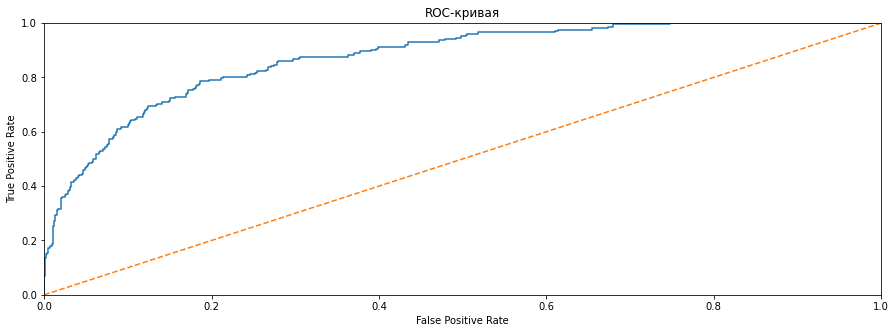

In [44]:
probabilities_test = forest.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('На тестовой выборке модель показала:\n   Мера F1:', f1_score_test_2, '\n   Мера AUC-ROC:', auc_roc,'\n')

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure(figsize=(15,5))

plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Метрика ROC учитывает результаты классификации и вероятность предсказания всех классов, метрика f1-score оценивает только результаты классификации, а значит оценивает как предсказывает модель и сколько делает ошибок на данной выборке. F1-score не может учесть вероятности предсказания класса для модели, поэтому на новых выборках для той же модели значение F1-score может  отличатся. 

Учитывая эффективность модели при разных пороговых значениях, метрика auc_roc точнее оценивает способность модели к предсказанию.

**Общий вывод**

Цель исследования состояла в том, чтобы спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Для этого нужно было построить модель с предельно большим значением F1-меры, от 0.59. 

Для определения лучшей модели сначала были обработаны исходные данные: 
    - подготовлены признаки, которые важны для прогноза, определен целевой признак;
    - категориальные признаки  преобразованы техникой OHE;
    - данные разделены на три выборки: обучающую, валидационную, тестовую;
    - все цифровые значения приведены к одному масштабу. 
    
Далее были обучены 2 вида модели без учета дисбаланса классов, среди них лучшей моделью стала модель решающего дерева с глубиной 5, ее f1_score составил 0,58. Был выявлен дисбаланс классов в пользу отрицательного, класс 0 составляет почти 80%. Матрица ошибок, метрики полноты и точности подтверждают, что модель делает много ошибок при оценке класса 1. 

На 3 моделях было использовано 3 метода устранения дисбаланса, для сравнения моделей использовали f1_score. В результате определили 2 лучшие модели:  

    forest2 (случайный лес с гиперпараметрами 1000 деревье, глубина 21, метод взвешивания классов) f1_score = 0.66 

    forest (случайный лес с гиперпараметрами 300 деревье, глубина 7, метод уменьшения выборки) f1_score = 0.66
   

**На порезультатам проверки на тестовой выборке Лучшая модель - модель случайного forest, на тестовой выборке f1-мера равна  0.62. Для прогнозирования следует использовать эту модель.**